# 1数据转换

In [1]:
# 导入所需的package
import seaborn as sns #用于画图
from bs4 import BeautifulSoup #用于爬取arxiv的数据
import re #用于正则表达式，匹配字符串的模式
import requests #用于网络连接，发送网络请求，使用域名获取对应信息
import json #读取数据，我们的数据为json格式的
import pandas as pd #数据处理，数据分析
import matplotlib.pyplot as plt #画图工具

def readArxivFile(path, columns=['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi','report-no', 'categories', 'license', 'abstract', 'versions','update_date', 'authors_parsed'], count=None):
    data  = []
    with open(path, 'r') as f: 
        for idx, line in enumerate(f): 
            if idx == count:
                break
                
            d = json.loads(line)
            d = {col : d[col] for col in columns}
            data.append(d)

    data = pd.DataFrame(data)
    return data 

## 1.1读取原始数据

In [2]:
data = readArxivFile('D:/Code/Github/data/arxiv-metadata-oai-snapshot.json', ['id', 'categories', 'authors','title','update_date'])

## 1.2爬取论文类别数据

In [3]:
#爬取所有的类别
website_url = requests.get('https://arxiv.org/category_taxonomy').text #获取网页的文本数据
soup = BeautifulSoup(website_url,'lxml') #爬取数据，这里使用lxml的解析器，加速
root = soup.find('div',{'id':'category_taxonomy_list'}) #找出 BeautifulSoup 对应的标签入口
tags = root.find_all(["h2","h3","h4","p"], recursive=True) #读取 tags

#初始化 str 和 list 变量
level_1_name = ""
level_2_name = ""
level_2_code = ""
level_1_names = []
level_2_codes = []
level_2_names = []
level_3_codes = []
level_3_names = []
level_3_notes = []

#进行
for t in tags:
    if t.name == "h2":
        level_1_name = t.text    
        level_2_code = t.text
        level_2_name = t.text
    elif t.name == "h3":
        raw = t.text
        level_2_code = re.sub(r"(.*)\((.*)\)",r"\2",raw) #正则表达式：模式字符串：(.*)\((.*)\)；被替换字符串"\2"；被处理字符串：raw
        level_2_name = re.sub(r"(.*)\((.*)\)",r"\1",raw)
    elif t.name == "h4":
        raw = t.text
        level_3_code = re.sub(r"(.*) \((.*)\)",r"\1",raw)
        level_3_name = re.sub(r"(.*) \((.*)\)",r"\2",raw)
    elif t.name == "p":
        notes = t.text
        level_1_names.append(level_1_name)
        level_2_names.append(level_2_name)
        level_2_codes.append(level_2_code)
        level_3_names.append(level_3_name)
        level_3_codes.append(level_3_code)
        level_3_notes.append(notes)

#根据以上信息生成dataframe格式的数据
df_taxonomy = pd.DataFrame({
    'group_name' : level_1_names,
    'archive_name' : level_2_names,
    'archive_id' : level_2_codes,
    'category_name' : level_3_names,
    'categories' : level_3_codes,
    'category_description': level_3_notes
    
})
df_taxonomy.head()

,group_name,archive_name,archive_id,category_name,categories,category_description
0,Computer Science,Computer Science,Computer Science,Artificial Intelligence,cs.AI,"Covers all areas of AI except Vision, Robotics..."
1,Computer Science,Computer Science,Computer Science,Hardware Architecture,cs.AR,Covers systems organization and hardware archi...
2,Computer Science,Computer Science,Computer Science,Computational Complexity,cs.CC,"Covers models of computation, complexity class..."
3,Computer Science,Computer Science,Computer Science,"Computational Engineering, Finance, and Science",cs.CE,Covers applications of computer science to the...
4,Computer Science,Computer Science,Computer Science,Computational Geometry,cs.CG,Roughly includes material in ACM Subject Class...


## 1.3取data的子集进行处理   
> 否则数据量太大，处理时间太长**  
  **抽取数据的5%进行分析**

In [14]:
#存储转换后的原始数据
data.to_csv('D:/Code/Github/data/data.csv',index = False)
df_taxonomy.to_csv('D:/Code/Github/data/categories.csv',index = False)
#对数据进行抽样
data = data.sample(frac=0.05,replace=False,random_state=1)
data.shape

(89846, 5)

## 1.4对categories进行处理  
> categories列中有很多，一篇论文同时属于很多的类别，只取第一个类别，放弃其他类别


In [35]:
print(data.categories.nunique())
data['categories'] = data.categories.str.split(' ',expand=True)[0]
data.categories.nunique()

9488


172

## 1.5数据连接

In [37]:
data_merge = data.merge(df_taxonomy,how='left',on='categories').sort_values(by = "update_date").drop_duplicates(['id','group_name'],keep = 'first')
data_merge.shape

(89847, 10)

 发现比原始抽样数据多了一行，经查明，原来是多了一行空行，进行删除

In [46]:
data_merge.dropna(how='any',subset=['categories'],inplace=True)
data_merge.shape

(89846, 10)

## 1.6存储转换后的数据，后面可以直接进行读取

In [47]:
data_merge.to_csv('D:/Code/Github/data/data_subset_merge.csv',index = False)


# 2数据探索性分析

## 2.1 查看数据的缺失信息  
可以看到group_name之后的部分列，都有缺失数据

In [48]:
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89846 entries, 77522 to 41836
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    89846 non-null  object
 1   categories            89846 non-null  object
 2   authors               89846 non-null  object
 3   title                 89846 non-null  object
 4   update_date           89846 non-null  object
 5   group_name            84229 non-null  object
 6   archive_name          84229 non-null  object
 7   archive_id            84229 non-null  object
 8   category_name         84229 non-null  object
 9   category_description  84229 non-null  object
dtypes: object(10)
memory usage: 7.5+ MB


## 2.2统计不同大类的论文数量  
- 可以看到物理学领域的论文数量最多，数学和计算机科学的其次，其他领域的论文数量都相对较少  
- 说明arxiv网站的论文大部分仍然集中在“物理学，数学，计算机科学”领域

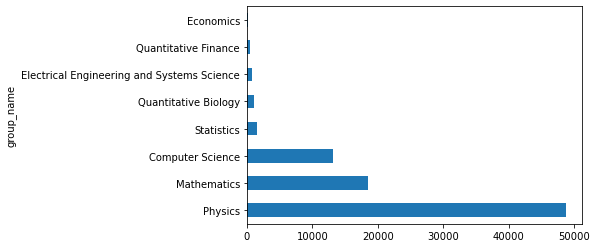

In [61]:
data_merge.groupby('group_name')['id'].agg('count').sort_values(ascending = False).plot(kind = 'barh')


## 2.3按年度统计论文数量的变化  
- 可以看到论文数量大体上呈现递增的趋势
- 2009年和2015年的数据偏高，有可能是抽样的随机因素，也有可能这两年的论文数量本来就比较高

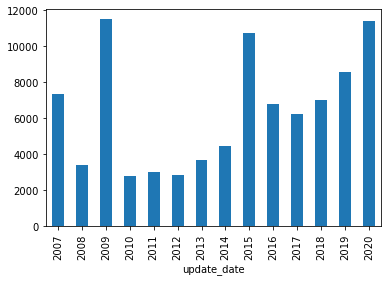

In [64]:
data_merge.groupby(pd.to_datetime(data_merge.update_date).dt.year)['id'].agg('count').plot(kind = 'bar')

## 2.4按月份统计论文发表数量
- 比较发现一年中5，6，10，11月份是论文出产最多的月份

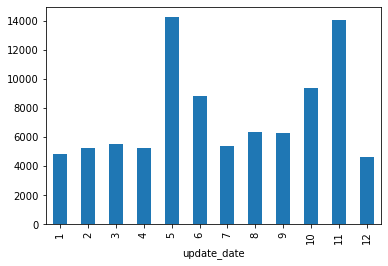

In [75]:
data_merge.groupby(pd.to_datetime(data_merge.update_date).dt.month)['id'].agg('count').plot(kind = 'bar')

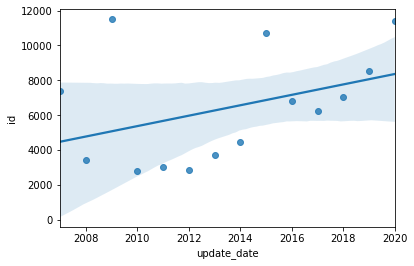

In [72]:
data_plot=data_merge.groupby(pd.to_datetime(data_merge.update_date).dt.year)['id'].agg('count').reset_index()
sns.regplot(data_plot.iloc[:,0],data_plot.iloc[:,1])

## 2.5统计不同小类论文的数量 
- 只绘制了前20种
- 高能物理，量子力学领域的论文数量最多

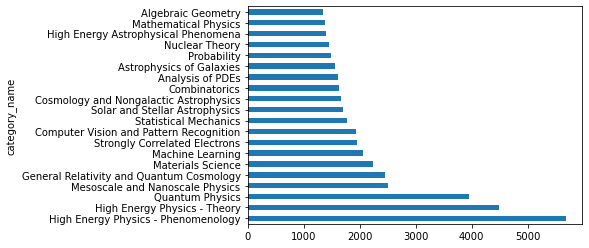

In [74]:
data_merge.groupby('category_name')['id'].agg('count').sort_values(ascending = False).head(20).plot(kind = 'barh')

# 3使用BI软件进行数据可视化分析

![图片1]("./pic/1.png")